[*********************100%***********************]  1 of 1 completed
C:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0278
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0056
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.3112e-04
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.7943e-04
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.8264e-04
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.1233e-04
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.4849e-04
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.7382e-04
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.0116e-04
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.1386e-04
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
Mean Squared Error (MSE): 84.09673730133416
Root Mean Squared Error (RMSE): 9.170427323812897
Mean Absolute Error (MAE): 7.816689226573524


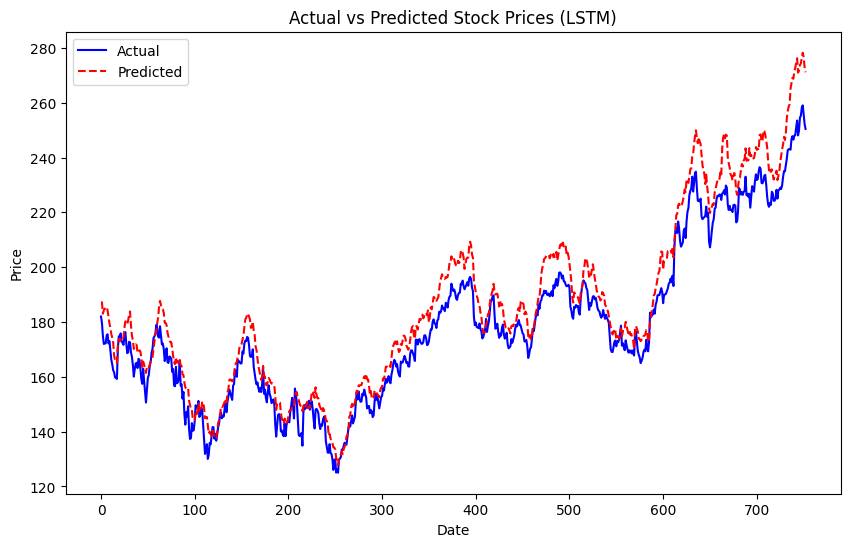

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Step 1: Load Stock Data (example: Apple Inc.)
data = yf.download('AAPL', start='2010-01-01', end='2025-01-01')

# Step 2: Calculate Technical Indicators (SMA, RSI, MACD)
data['SMA'] = data['Close'].rolling(window=14).mean()

# Calculate daily returns
delta = data['Close'].diff()

# Separate gains and losses
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()

# Calculate RSI
RS = gain / loss
data['RSI'] = 100 - (100 / (1 + RS))

# MACD Calculation
data['MACD'] = data['Close'].ewm(span=12, adjust=False).mean() - data['Close'].ewm(span=26, adjust=False).mean()

# Remove NaN values created by rolling or technical indicators
data = data.dropna()

# Step 3: Define Features and Target Variable
X = data[['SMA', 'RSI', 'MACD']].values
y = data['Close'].values

# Step 4: Scale Data
scaler_X = MinMaxScaler(feature_range=(0, 1))  # Scaler for features
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler(feature_range=(0, 1))  # Scaler for target
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))  # Reshaping y for scaling

# Step 5: Reshape for LSTM (3D shape: [samples, timesteps, features])
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Step 6: Split Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# Step 7: Build and Train the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Step 8: Make Predictions
predictions = model.predict(X_test)

# Step 9: Inverse Scale the Predictions and Actual Values
predictions_rescaled = scaler_y.inverse_transform(predictions)  # Inverse transform predictions
y_test_rescaled = scaler_y.inverse_transform(y_test)  # Inverse transform y_test

# Step 10: Calculate and Print RMSE, MAE, and MSE
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

# Step 11: Plot Actual vs Predicted Prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual', color='blue')
plt.plot(predictions_rescaled, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Stock Prices (LSTM)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
